In [145]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [146]:
TrainingColums = ["nTracks","B_P","gamma_PT","Kst_892_0_PT","B_Cone3_B_ptasy","B_ETA"]


sharedColums = ["nTracks","gamma_PT","B_P","B_Cone3_B_ptasy", 
                "B_ETA", "B_MINIPCHI2","B_SmallestDeltaChi2OneTrack",
                "B_FD_OWNPV","piminus_PT", "piminus_IP_OWNPV"]


columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT","Kst_892_0_IP_OWNPV","Kplus_PT", "Kplus_IP_OWNPV" ],
              "pipi" : sharedColums + ["rho_770_0_PT","rho_770_0_IP_OWNPV","piplus_PT","piplus_IP_OWNPV"]}


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"kpi" : "#066bd6", "kpisw"  : "#d60645",  "pipi" : "#2fad66", "rw":"#2fad66","ratio":"#000000"}

In [147]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
    pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
    pipi_up_MC_df        = pipi_TTree_MC_up.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
    pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
    pipi_down_MC_df      = pipi_TTree_MC_down.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)


#Add min() colum to the dataframe
dataframes["kpi"  ]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpi"  ]["Kplus_IP_OWNPV"]),list(dataframes["kpi"  ]["piminus_IP_OWNPV"])) ]
dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpisw"]["Kplus_IP_OWNPV"]),list(dataframes["kpisw"]["piminus_IP_OWNPV"])) ]

columns["kpi" ].append("min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" )
columns["pipi"].append("min(piminus_IP_OWNPV,piplus_IP_OWNPV)")


print("Data has been loaded")

Data has been loaded


In [148]:
# divide original samples into training ant test parts
kpiMC_train, kpiMC_test = train_test_split(dataframes["kpi"])
# divide target samples into training ant test parts
kpiSW_train, kpiSW_test = train_test_split(dataframes["kpisw"])

kpiMC_weights_train, kpiMC_weights_test = np.ones(len(kpiMC_train)),      np.ones(len(kpiMC_test))
kpiSW_weights_train, kpiSW_weights_test = kpiSW_train["NB0_Kpigamma_sw"], kpiSW_test["NB0_Kpigamma_sw"]
print("Data has been Split")

Data has been Split


Y: [[ 2.44923314e-04  1.65872203e-03  3.40021125e-03  4.64340821e-03
   6.15348712e-03  6.43050384e-03  7.15513902e-03  6.97440251e-03
   7.63991827e-03  6.89501357e-03  6.13152848e-03  5.33594999e-03
   5.21940028e-03  4.04714662e-03  3.41879164e-03  2.93063414e-03
   2.69922383e-03  2.08100361e-03  1.55906358e-03  1.24488609e-03
   1.14691676e-03  6.43557122e-04  5.23629154e-04  3.46270892e-04
   2.04384283e-04  1.11482336e-04  6.08085469e-05  2.87151472e-05
   1.85803893e-05  1.68912630e-06  1.01347578e-05  5.06737891e-06
   1.68912630e-06  1.68912630e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.96098778e-05  4.60643132e-04  1.37346334e-03  2.66921443e-03
   3.67500872e-03  4.28208143e-03  5.20101035e-03  5.54837044e-03
   6.46283865e-03  6.17461624e-03  5.9

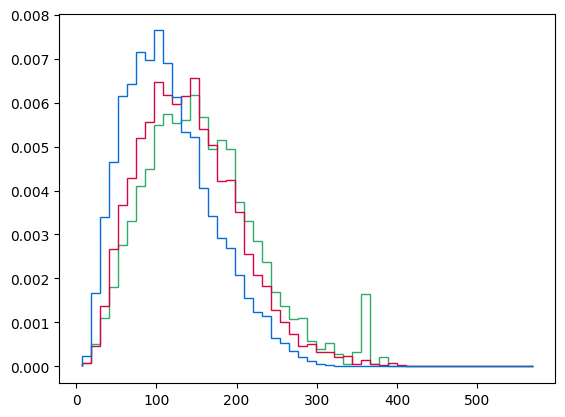

In [153]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=50,  learning_rate=0.1, max_depth=3, min_samples_leaf=100, gb_args={'subsample': 0.4})
#GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=2)
GradientBoostedReweighter.fit(kpiMC_train[TrainingColums], kpiSW_train[TrainingColums])

FittedWeights = GradientBoostedReweighter.predict_weights(kpiMC_test[TrainingColums])
variable = "nTracks"

hist_kpi_y,   hist_kpi_x,   _      = plt.hist( [kpiMC_test[variable], kpiSW_test[variable], kpiMC_test[variable]], 
                                                weights = [kpiMC_weights_test,kpiSW_weights_test,FittedWeights], 
                                                color   = [colors["kpi"],colors["kpisw"],colors["rw"]], 
                                                label   = ["Kpi MC","Kpi Sample","Kpi MC Reweighted"], 
                                                **hist_style)


print("Y:",  hist_kpi_y)
print("X:",  hist_kpi_x)
plt.show()

In [149]:

def CreateDoublePlot(variable, Reweighter, TrainingColums):

    #Create Canvas
    canvas, (disti,ratio) = plt.subplots(2,1, gridspec_kw={"height_ratios" : [2,1] },figsize=(8, 7))
    canvas.tight_layout()

    #Create Histograms
    xLowerBound = max( min(kpiMC_test[variable]), min(kpiSW_test[variable]) )
    xUpperBound = min( max(kpiMC_test[variable]), max(kpiSW_test[variable]) )
   
    #Compute New Weights
    FittedWeights = Reweighter.predict_weights(kpiMC_test[TrainingColums])

    #Draw Histograms
    hist_kpi_y,   hist_kpi_x,   _      = disti.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpi"],  label="Kpi MC",     **hist_style)
    hist_kpisw_y, hist_kpisw_x, _      = disti.hist(kpiSW_test[variable], range=(xLowerBound, xUpperBound), color=colors["kpisw"], label="Kpi Sample", **hist_style)
    hist_trained_kpi_y, hist_kpi_x, _  = disti.hist(kpiMC_test[variable], range=(xLowerBound, xUpperBound), color=colors["rw"], weights=FittedWeights, label="Kpi MC Reweighted",  **hist_style)

    #Plot Ratio Data
    ratio_data        = np.nan_to_num( (hist_kpisw_y / hist_kpi_y),         nan=-1, posinf=-1, neginf=-1)
    ratio_data_fitted = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)

    ratio.scatter(hist_kpisw_x[:-1], ratio_data, c=colors["kpi"], s=5)
    ratio.scatter(hist_kpisw_x[:-1], ratio_data_fitted, c=colors["pipi"], s=5)

    #Calculate KSR
    KS_before = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=kpiMC_weights_test, weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    KS_After  = ks_2samp_weighted(kpiMC_test[variable], kpiSW_test[variable], weights1=FittedWeights,      weights2=np.ones(len(kpiSW_test[variable]), dtype=float))
    KS_resid = KS_before - KS_After

    #Styles
    disti.set_title(f"{variable}   KSR: {np.round(KS_resid,4)}")
    disti.grid(axis="both", linestyle="dashed", alpha=0.5)
    disti.set_xlim(xLowerBound, xUpperBound)
    disti.xaxis.set_tick_params(which = "both",labelbottom=False, bottom=False)
    disti.legend()

    ratio.grid(axis="both", linestyle="dashed", alpha=0.5)
    ratio.set_xlim(xLowerBound, xUpperBound)
    ratio.set_yscale("log")

    plt.savefig(f"../imgs/{variable}.png")

    return KS_resid


In [150]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=250,  learning_rate=0.1, max_depth=4, min_samples_leaf=100, gb_args={'subsample': 0.4})
#GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=2)
GradientBoostedReweighter.fit(kpiMC_train[TrainingColums], kpiSW_train[TrainingColums])

GBReweighter(gb_args={'subsample': 0.4}, learning_rate=0.1, max_depth=4,
             min_samples_leaf=100, n_estimators=250)

/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/493455051.py:20: RuntimeWarning: divide by zero encountered in divide
  ratio_data        = np.nan_to_num( (hist_kpisw_y / hist_kpi_y),         nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/493455051.py:20: RuntimeWarning: invalid value encountered in divide
  ratio_data        = np.nan_to_num( (hist_kpisw_y / hist_kpi_y),         nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/493455051.py:21: RuntimeWarning: divide by zero encountered in divide
  ratio_data_fitted = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn/T/ipykernel_17237/493455051.py:21: RuntimeWarning: invalid value encountered in divide
  ratio_data_fitted = np.nan_to_num( (hist_kpisw_y / hist_trained_kpi_y), nan=-1, posinf=-1, neginf=-1)
/var/folders/gs/45vsy3wn1hsgjd42983r8rlc0000gn

Total Residual: 1.1333368464369407


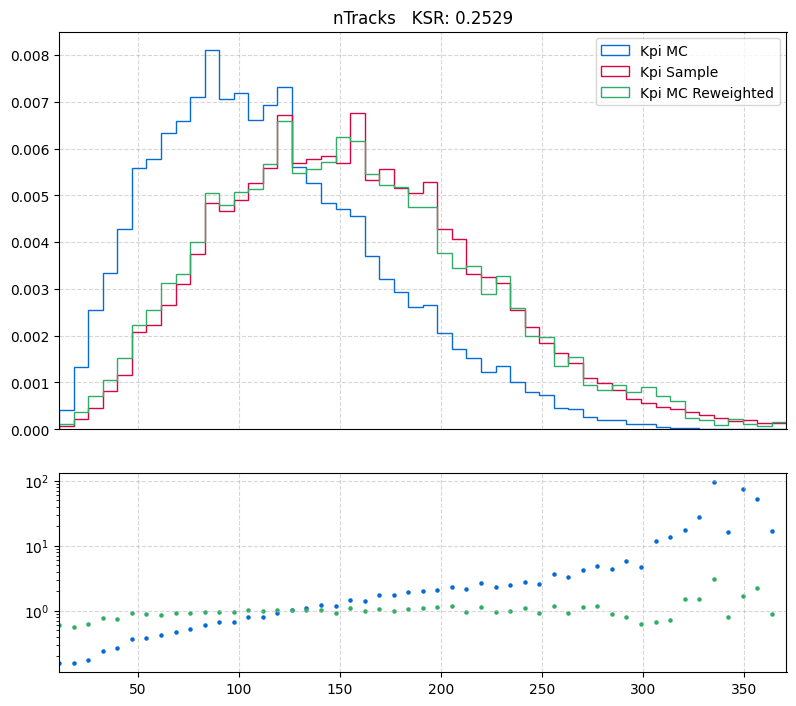

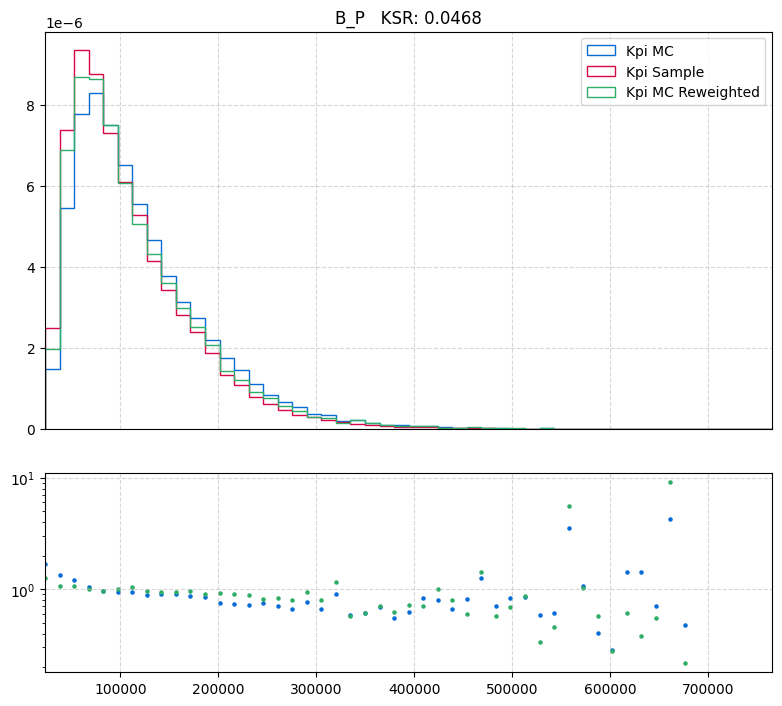

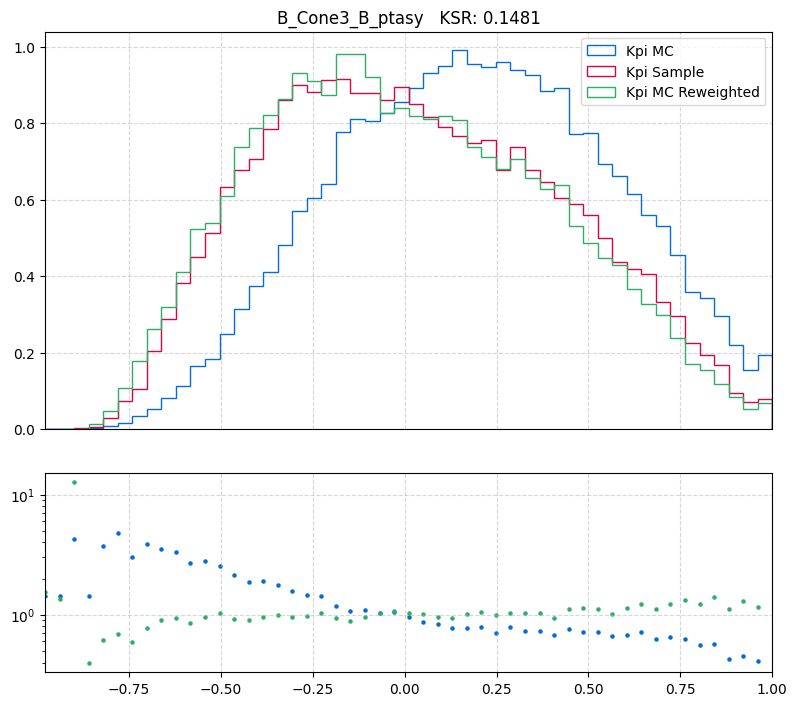

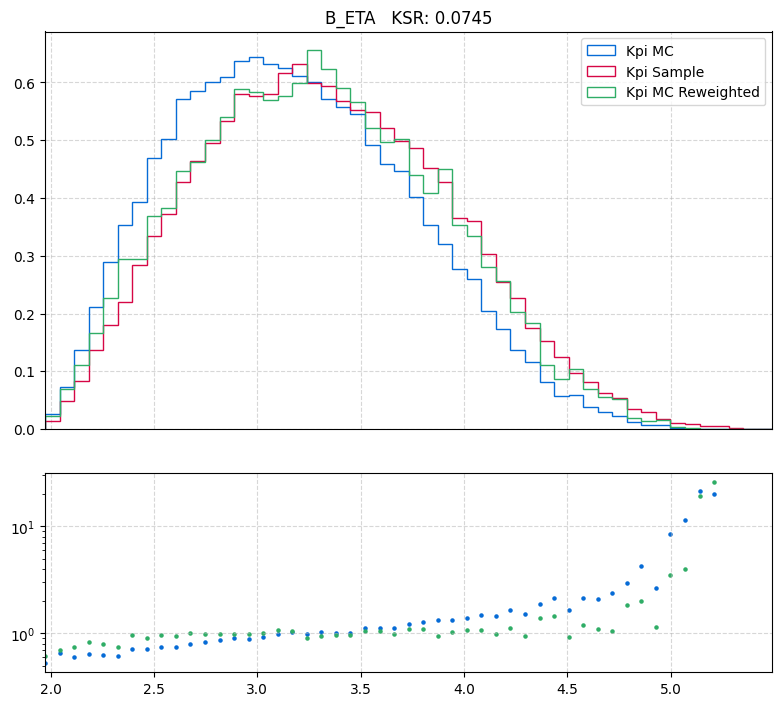

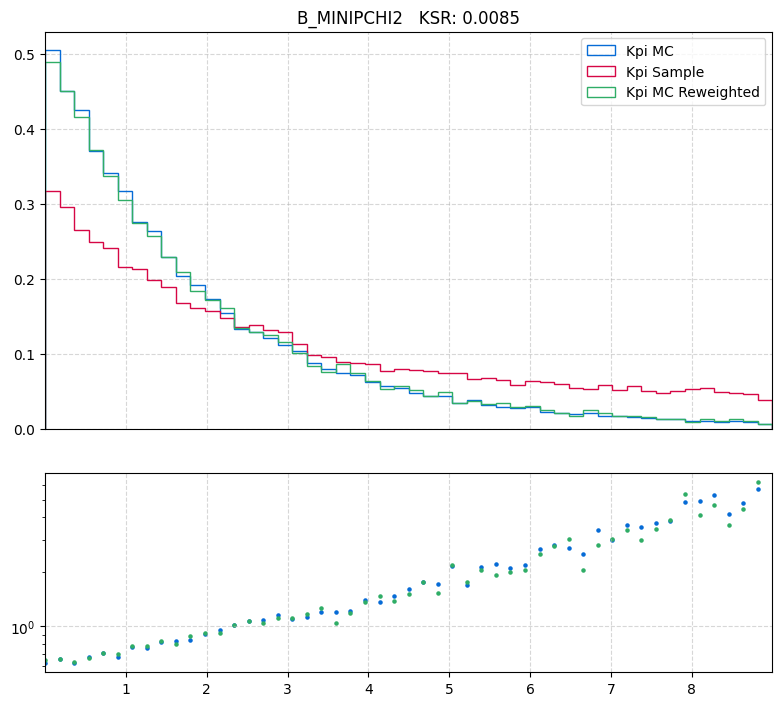

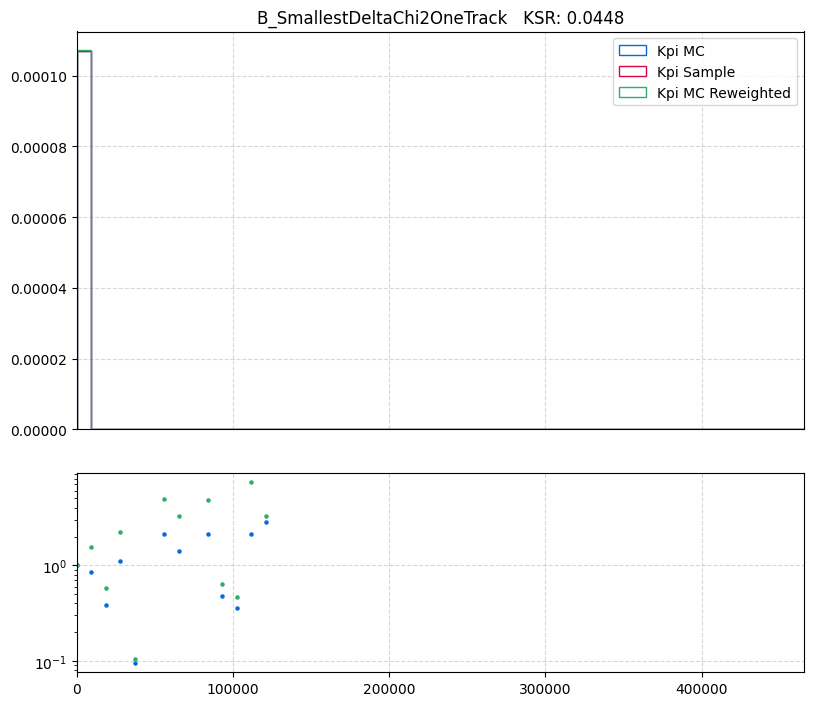

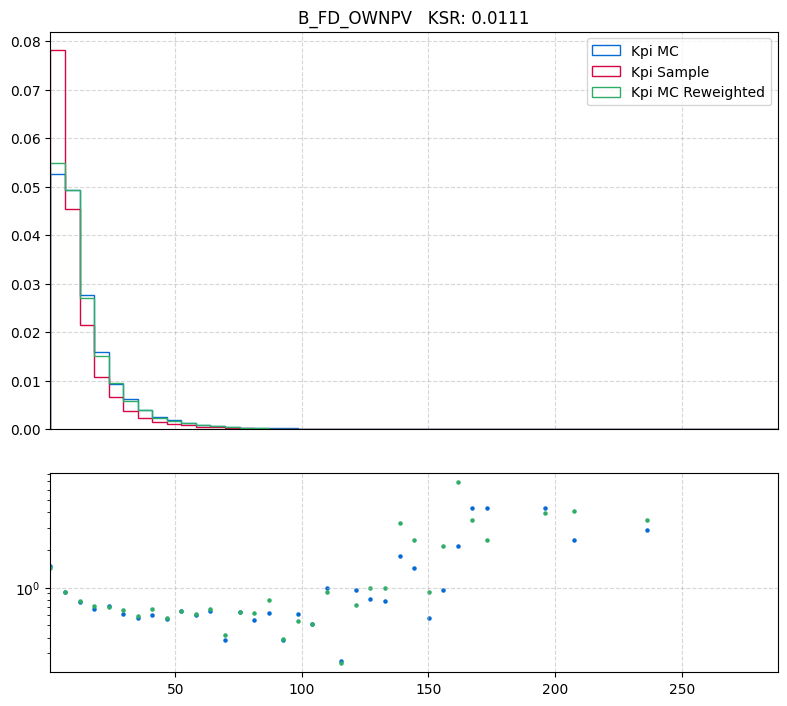

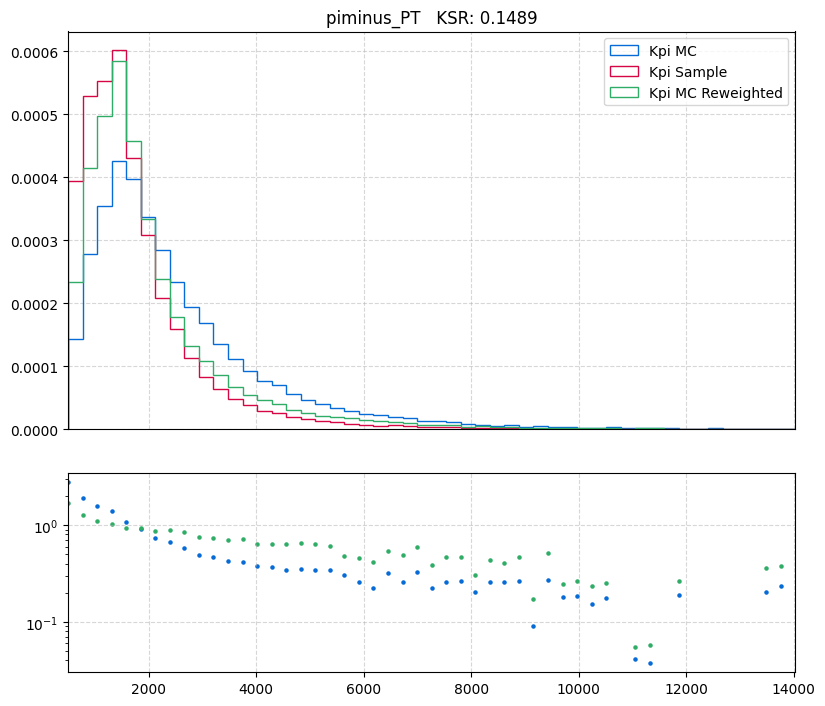

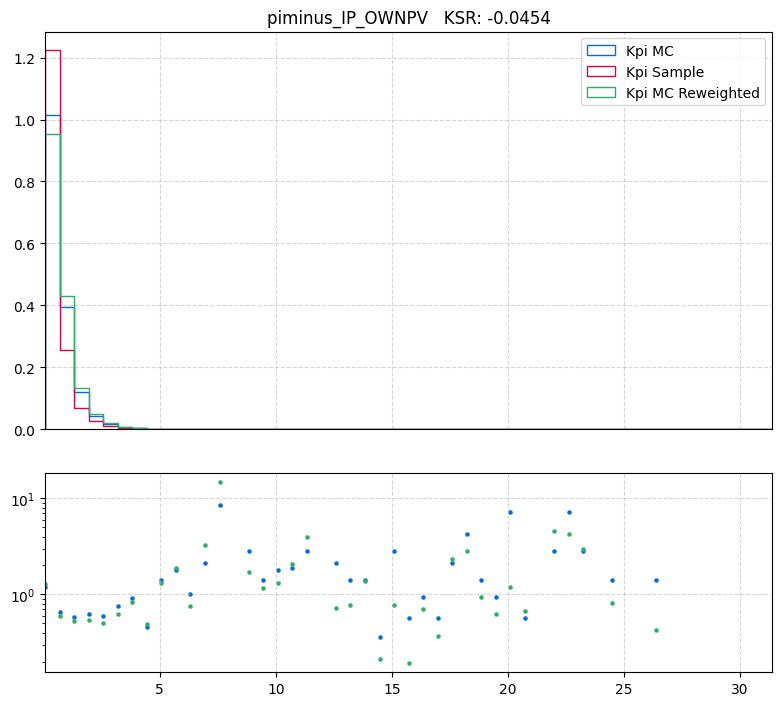

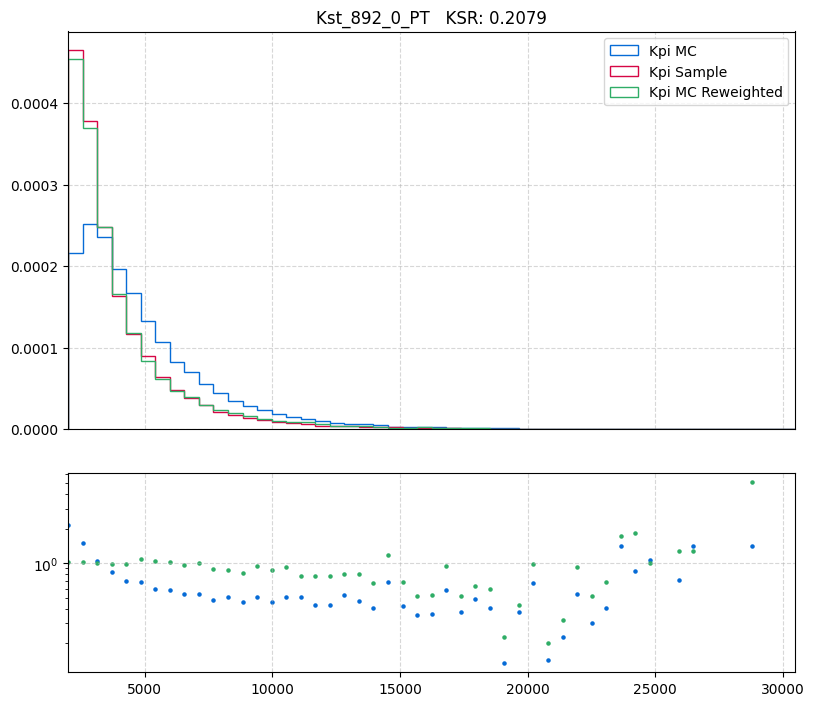

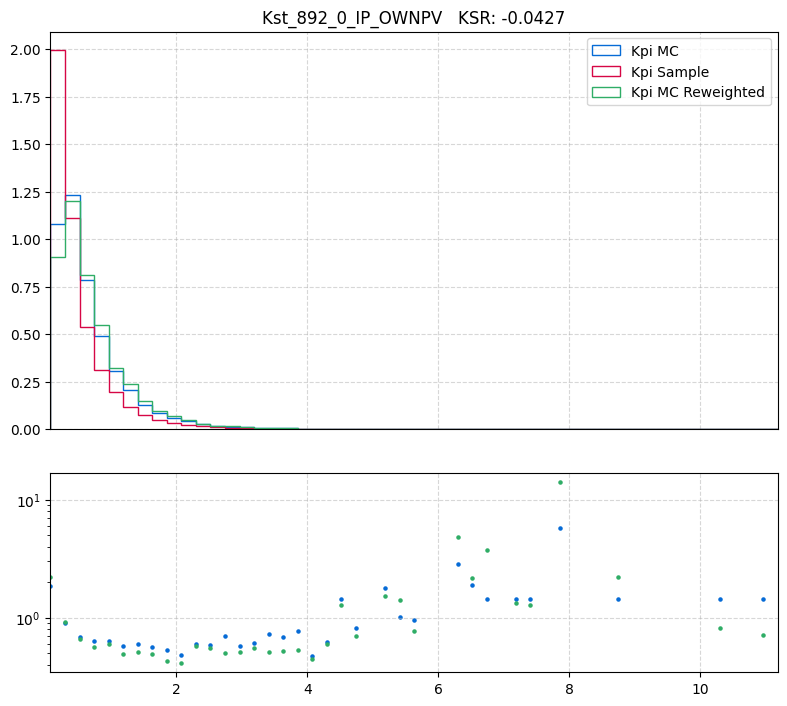

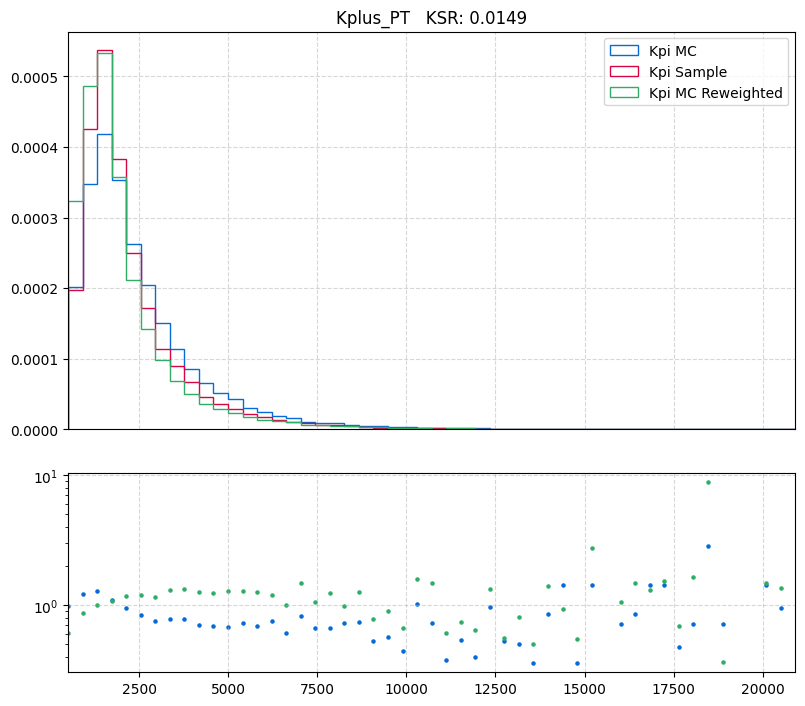

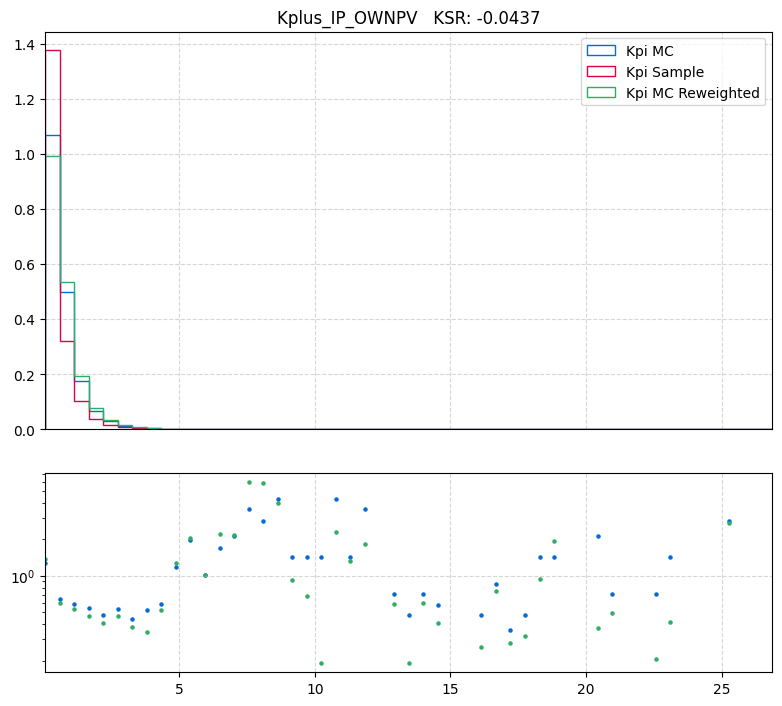

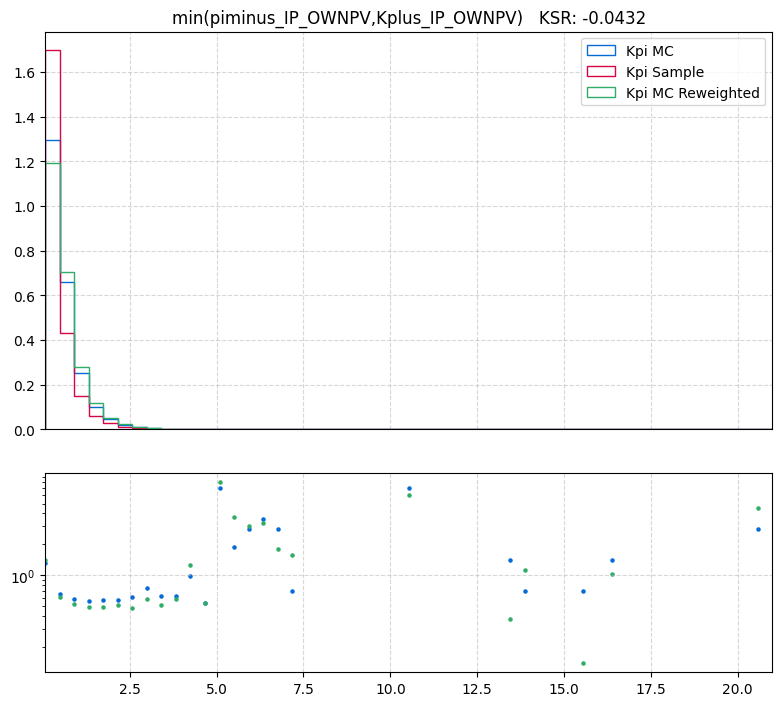

In [ ]:
KSR_Gamma = 0

for var in columns["kpi"]:

    KSR_Gamma += CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter, TrainingColums=TrainingColums)
    
print("Total Residual:", KSR_Gamma)


In [ ]:
# TrainingColumsSansGamma = TrainingColums.copy()
# TrainingColumsSansGamma.remove("gamma_PT")

# GradientBoostedReweighterSansGamma = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, gb_args={'subsample': 0.4})
# #GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=2)
# GradientBoostedReweighterSansGamma.fit(kpiMC_train[TrainingColumsSansGamma], kpiSW_train[TrainingColumsSansGamma])

In [ ]:
#Code to test if gamma_PT increases Performance

# KSR_Gamma = KSR_sansGamma = 0


# for var in columns["kpi"]:

#     if var == "gamma_PT":
#         continue

#     KSR_Gamma     += abs(CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighter,          TrainingColums=TrainingColums))
#     KSR_sansGamma += abs(CreateDoublePlot(variable=var, Reweighter=GradientBoostedReweighterSansGamma, TrainingColums=TrainingColumsSansGamma))

# print("With Gamma    :", KSR_Gamma)
# print("Without Gamma :", KSR_sansGamma)